## Transfer learning with TensorFlow, Part 1: Feature Extraction

In [1]:
!nvidia-smi

Tue Sep 13 02:51:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Becoming one with the data

In [2]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref=zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2022-09-13 02:51:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.196.128, 64.233.191.128, 173.194.74.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.196.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   175MB/s    in 0.9s    

2022-09-13 02:51:43 (175 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import os
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent'):
    print(f'Number of Directories (Classes): {len(dirnames)} Number of images: {len(filenames)} in {dirpath}')

Number of Directories (Classes): 2 Number of images: 0 in 10_food_classes_10_percent
Number of Directories (Classes): 10 Number of images: 0 in 10_food_classes_10_percent/train
Number of Directories (Classes): 0 Number of images: 75 in 10_food_classes_10_percent/train/sushi
Number of Directories (Classes): 0 Number of images: 75 in 10_food_classes_10_percent/train/steak
Number of Directories (Classes): 0 Number of images: 75 in 10_food_classes_10_percent/train/pizza
Number of Directories (Classes): 0 Number of images: 75 in 10_food_classes_10_percent/train/ice_cream
Number of Directories (Classes): 0 Number of images: 75 in 10_food_classes_10_percent/train/grilled_salmon
Number of Directories (Classes): 0 Number of images: 75 in 10_food_classes_10_percent/train/chicken_wings
Number of Directories (Classes): 0 Number of images: 75 in 10_food_classes_10_percent/train/chicken_curry
Number of Directories (Classes): 0 Number of images: 75 in 10_food_classes_10_percent/train/hamburger
Number

# Create Data loaders

In [4]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE=(224,224)
BATCH_SIZE=32

train_dir='10_food_classes_10_percent/train/'
test_dir='10_food_classes_10_percent/test/'

train_datagen=ImageDataGenerator(rescale=1/255.)
test_datagen=ImageDataGenerator(rescale=1/255.)

print('Training Images:')
train_data_10_percent=train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

print('Testing Images:')
test_data=train_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
)

Training Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks

In [5]:
# Functionize and create TensorBoard callback
import tensorflow as tf
import datetime

def create_tensorboard_callback(dir_name, experiment_name,):
    log_dir=dir_name+'/'+experiment_name+'/'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard logfiles to: {log_dir}....')
    return tensorboard_callback

# Creating models using TensorFlow Hub

In [6]:
# Comparing the two TF hub models
resnet_url='https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5'
efficientnet_url='https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

In [7]:
# Impoirt dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

# create_model() func to create model from TF hub URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  

## Creating and testing ResNet TensorFlow Hub fearture extraction model

In [8]:
# Create Resnet Model
resnet_model=create_model(resnet_url,
                          num_classes=train_data_10_percent.num_classes)


In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_lyaer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [10]:
from tensorflow.python import metrics
# Compile the ResNet model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'],
)

In [11]:
# Fit the ResNet model to the data
resnet_history=resnet_model.fit(train_data_10_percent,
                               epochs=5,
                               steps_per_epoch=len(train_data_10_percent),
                               validation_data=test_data,
                               validation_steps=len(test_data),
                               callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                                                      experiment_name='resnet50V2')]
                               )

Saving TensorBoard logfiles to: tensorflow_hub/resnet50V2/20220913-025200....
Epoch 1/5
24/24 [==============================] - 33s 766ms/step - loss: 1.8180 - accuracy: 0.3773 - val_loss: 1.1013 - val_accuracy: 0.6672
Epoch 2/5
24/24 [==============================] - 16s 691ms/step - loss: 0.8511 - accuracy: 0.7520 - val_loss: 0.8143 - val_accuracy: 0.7388
Epoch 3/5
24/24 [==============================] - 17s 719ms/step - loss: 0.5979 - accuracy: 0.8227 - val_loss: 0.7331 - val_accuracy: 0.7576
Epoch 4/5
24/24 [==============================] - 16s 685ms/step - loss: 0.4581 - accuracy: 0.8853 - val_loss: 0.7073 - val_accuracy: 0.7656
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.3652 - accuracy: 0.9120 - val_loss: 0.6752 - val_accuracy: 0.7704


In [12]:
# Create function to plot loss curves

import matplotlib.pyplot as plt

# Plot validation and training ccurves
def plot_loss_curves(history):
    """Returns seperate loss curves for training and validation metrics"""

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    accuracy=history.history['accuracy']
    val_accuracy=history.history['val_accuracy']

    epochs=range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs,loss,label='training_loss')
    plt.plot(epochs,val_loss,label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs,accuracy,label='training_accuracy')
    plt.plot(epochs,val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()


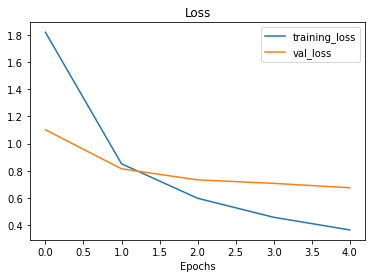

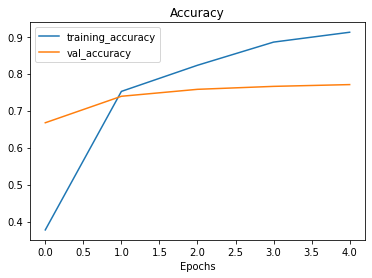

In [13]:
plot_loss_curves(resnet_history)

## Creating and testing EfficientNetB0 TensorFlow Hub Feature Extraction model

In [14]:
# Create EfficientNetB0 feature extractor model
efficientnet_model=create_model(model_url=efficientnet_url,
                                num_classes=train_data_10_percent.num_classes)

#Compile EfficientNet model
efficientnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model
efficientnet_history=efficientnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    validation_steps=len(test_data),
    callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub',
                                           experiment_name='efficientnetb0') ]
)

Saving TensorBoard logfiles to: tensorflow_hub/efficientnetb0/20220913-030521....
Epoch 1/5
24/24 [==============================] - 26s 733ms/step - loss: 1.8252 - accuracy: 0.4667 - val_loss: 1.2797 - val_accuracy: 0.7584
Epoch 2/5
24/24 [==============================] - 16s 688ms/step - loss: 1.0498 - accuracy: 0.7853 - val_loss: 0.8530 - val_accuracy: 0.8260
Epoch 3/5
24/24 [==============================] - 15s 657ms/step - loss: 0.7462 - accuracy: 0.8373 - val_loss: 0.6881 - val_accuracy: 0.8524
Epoch 4/5
24/24 [==============================] - 16s 671ms/step - loss: 0.6023 - accuracy: 0.8600 - val_loss: 0.6040 - val_accuracy: 0.8576
Epoch 5/5
24/24 [==============================] - 15s 661ms/step - loss: 0.5078 - accuracy: 0.8867 - val_loss: 0.5520 - val_accuracy: 0.8616
